In [1]:
import torch
from torch import nn, Tensor
import torch.optim as optim
import numpy as np
import PIL
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import (
    Dataset,
    DataLoader,
)

/home/jianant/.conda/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import ganomaly_model

In [3]:
import utils

In [4]:
img_shape = [256,256]
latent_vec_size = 100
n_features = 64
lr_g= 1e-4
lr_d = 5e-5
beta1 = 0.5
beta2 = 0.999
wgp = 1
wadv = 1
wcon = 5
wenc = 1
batch_size = 16
num_epochs = 100
bce_loss = nn.BCELoss()
l1_loss = nn.L1Loss()
l2_loss = nn.MSELoss()

In [5]:
dataset = utils.MvtecDataset("bottle")

In [6]:
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

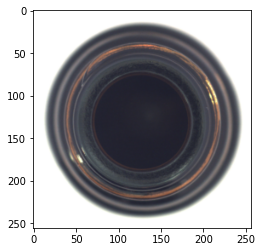

In [7]:
test_img = next(iter(train_loader))
plt.imshow(np.rollaxis(test_img[0].numpy(), 0,3))

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
model = ganomaly_model.Ganomaly([256,256], 100, 3, 64, 2, device)

In [10]:
opt_gen = optim.Adam(model.generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
opt_disc = optim.Adam(model.discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))

In [11]:
def train_one_epoch(batch_size: int, mini_batch: Tensor, loss_fun: str):
    #Train the discriminator one step
    real = mini_batch.to(device)
    fake, latent_i, latent_o = model.generator(real)
    disc_real = model.discriminator(real)
    disc_fake = model.discriminator(fake)
    disc_real = disc_real.reshape(-1)
    disc_fake = disc_fake.reshape(-1)
    if loss_fun == "JS":
        loss_disc_real = bce_loss(torch.sigmoid(disc_real), torch.ones_like(disc_real))
        loss_disc_fake = bce_loss(torch.sigmoid(disc_fake), torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real+loss_disc_fake)/2
    if loss_fun == "WD":
        loss_gp = utils.gradient_penalty(model.discriminator, real, fake, device=device)
        loss_disc = torch.mean(disc_fake) - torch.mean(disc_real) + wgp*loss_gp
    model.discriminator.zero_grad()
    loss_disc.backward(retain_graph=True)
    opt_disc.step()
    
    # Train the generator one step
    output = model.discriminator(fake)
    output = output.reshape(-1)
    if loss_fun == "JS":
        loss_gen_adv = bce_loss(torch.sigmoid(output), torch.ones_like(output))
    if loss_fun == "WD":
        loss_gen_adv = -torch.mean(output)
    loss_gen_con = l1_loss(real, fake)
    loss_gen_enc = l2_loss(latent_i, latent_o)
    loss_gen = wadv*loss_gen_adv + wcon*loss_gen_con + wenc*loss_gen_enc
    model.generator.zero_grad()
    loss_gen.backward()
    opt_gen.step()
    return real[0], fake[0], loss_disc, loss_gen

In [12]:
for epoch in range(num_epochs):
    #loss_hist = []
    for batch_idx, mini_batch in enumerate(train_loader):
        real_img, fake_img, loss_disc, loss_gen = train_one_epoch(batch_size, mini_batch, loss_fun="JS")
        #loss_hist.append([loss_disc, loss_gen])
    if (epoch%10) == 0:
        print(f"epoch {epoch}   loss_disc: {loss_disc:.2f}   loss_gen: {loss_gen:.2f}")
        real_img = real_img.detach().cpu()
        real_img = real_img.numpy()
        real_img = np.rollaxis(real_img, 0,3)
        fake_img = fake_img.detach().cpu()
        fake_img = fake_img.numpy()
        fake_img = np.rollaxis(fake_img, 0,3)
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(real_img)
        axs[0].axis("off")
        axs[1].imshow(fake_img)
        axs[1].axis("off")
        fig.savefig("saved_images/%d.png" % epoch)
        plt.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 0   loss_disc: 1.40   loss_gen: 25.82


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 10   loss_disc: 0.01   loss_gen: 8.55


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 20   loss_disc: 0.00   loss_gen: 9.15


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 30   loss_disc: 0.00   loss_gen: 10.19


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 40   loss_disc: 0.01   loss_gen: 6.18


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 50   loss_disc: 0.06   loss_gen: 4.56


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 60   loss_disc: 0.82   loss_gen: 1.83


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 70   loss_disc: 0.58   loss_gen: 0.70


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch 80   loss_disc: 0.36   loss_gen: 3.88
epoch 90   loss_disc: 0.07   loss_gen: 8.15


In [13]:
torch.save(model.state_dict(), "01152023")

In [18]:
test_set = utils.MvtecDataset_test("bottle", "anomaly")
test_loader = DataLoader(dataset=test_set, batch_size=63, shuffle=False)

In [19]:
test_set.__len__()

63

In [20]:
test_img = next(iter(test_loader))

In [21]:
print(test_img.shape)

torch.Size([63, 3, 256, 256])


In [22]:
recon_img, latent_i_test, latent_o_test = model.generator(test_img.to(device))

In [23]:
recon_img = recon_img.detach().cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructed sample')

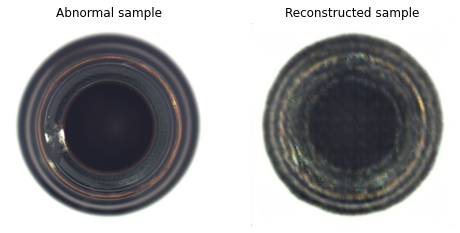

In [33]:
visual_idx = 26
visual_img = test_img[visual_idx].numpy()
fig, axs = plt.subplots(1,2, figsize=(8,8))
axs[0].imshow(np.rollaxis(visual_img, 0,3))
axs[0].axis("off")
axs[0].set_title("Abnormal sample")
axs[1].imshow(np.rollaxis(recon_img[visual_idx].numpy(), 0,3))
axs[1].axis("off")
axs[1].set_title("Reconstructed sample")

In [26]:
latent_i_a = latent_i_test.detach().cpu().numpy()
latent_o_a = latent_o_test.detach().cpu().numpy()

In [27]:
print(latent_i_a.shape)

(63, 100, 1, 1)


In [28]:
anomaly_score_a = np.squeeze(np.mean(np.square(latent_i_a - latent_o_a), axis=1))

In [29]:
anomaly_score_a.shape

(63,)

Text(0.5, 1.0, 'Anomaly score distribution for abnormal samples')

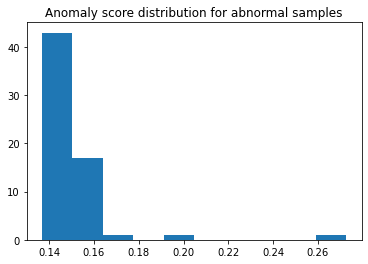

In [48]:
plt.hist(anomaly_score_a)
plt.title("Anomaly score distribution for abnormal samples")

In [39]:
import gc

In [40]:
del test_img
del recon_img
gc.collect()

3304

In [46]:
torch.cuda.empty_cache()

In [41]:
test_set_2 =  utils.MvtecDataset_test("bottle", "good")
test_set_2.__len__()

20

In [42]:
test_loader_2 = DataLoader(dataset=test_set, batch_size=20, shuffle=False)

In [43]:
test_img_2 = next(iter(test_loader_2))

In [47]:
recon_img_2, latent_i_test_2, latent_o_test_2 = model.generator(test_img_2.to(device))

RuntimeError: CUDA out of memory. Tried to allocate 164.00 MiB (GPU 0; 15.78 GiB total capacity; 14.00 GiB already allocated; 159.12 MiB free; 14.27 GiB reserved in total by PyTorch)

In [ ]:
latent_i_n = latent_i_test_2.detach().cpu().numpy()
latent_o_n = latent_o_test_2.detach().cpu().numpy()

In [38]:
anomaly_score_n = np.squeeze(np.mean(np.square(latent_i_a - latent_o_a), axis=1))

(array([24.,  7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.00510027, 0.00754438, 0.00998849, 0.01243261, 0.01487672,
        0.01732084, 0.01976495, 0.02220907, 0.02465318, 0.02709729,
        0.02954141], dtype=float32),
 <BarContainer object of 10 artists>)

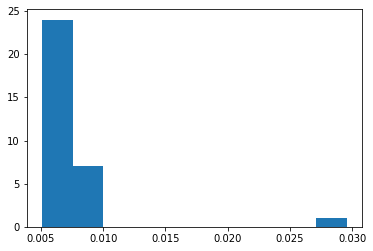

In [31]:
plt.hist(anomaly_score_n)